# Universal Count Model

Comparison to baselines

### Table of contents

1. [**Data**](#data)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)



The above only holds for one covariate dimension that we looked at. To look at the intrinsic degree of freedom for a neuron, it may be more informative and convenient to look at the softmax weights and biases that connect the GP functions to the spike count distribution. We now load the pre-softmax weights and biases. Each neuron has its own set of weights and biases $W_n$ and $\mathbf{b}_n$. Note we used a exponential-quadratic expansion for $\phi(\cdot)$. This expansion combines the quadratic basis expansion with an exponential mapping, i.e. for a vector $\mathbf{f} = (f_1, f_2)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_1^2, f_2^2, e^{f_1}, e^{f_2}, f_1 f_2)
$$

and for a vector $\mathbf{f} = (f_1, f_2, f_3)$ we obtain 

$$
\phi(\mathbf{f}) = (f_1, f_2, f_3, f_1^2, f_2^2, f_3^2, e^{f_1}, e^{f_2}, e^{f_3}, f_1 f_2, f_2 f_3, f_1 f_3)
$$

and so on. The last example here corresponds to the case of $C = 3$ as in the model that we loaded. The probability of spike count $k$ for neuron $n$ is then computed as 

$$
P_{nk} = \text{softmax}\left( W_n \cdot \phi(\mathbf{f}_n) + \mathbf{b}_n \right)_k
$$

Different basis expansions $\phi(\cdot)$ are defined in ```scripts/lib/models.py```.

<a id="likelihood"></a>
## Count distributions

In [3]:
likelihood_type = 'ZIP'# 'NB', 'ZIP', 'P'

In [4]:
neurons = 1
tbin = 0.1

### count process output ###
if likelihood_type == 'NB':
    r_inv = 0.0*torch.ones(neurons)
    likelihood = nprb.likelihoods.Negative_binomial(tbin, neurons, 'exp', r_inv)
elif likelihood_type == 'ZIP':
    alpha = 0.95*torch.ones(neurons)
    likelihood = nprb.likelihoods.ZI_Poisson(tbin, neurons, 'exp', alpha)
elif likelihood_type == 'CMP':
    log_nu = 1.*torch.ones(neurons)
    likelihood = nprb.likelihoods.COM_Poisson(tbin, neurons, 'exp', log_nu)
elif likelihood_type == 'P':
    likelihood = nprb.likelihoods.Poisson(tbin, neurons, 'exp')

### set data ###
max_count = 10
spikes = torch.arange(max_count)[None, :]
likelihood.set_Y(spikes, max_count)

### compute NLL ###
trials = 2
rates = 10.0*torch.ones(trials, neurons, max_count) # primary parameter
#disper_param = 0.1*torch.ones(trials, neurons, max_count) # dispersion parameter
nll = likelihood.nll(0, rates, spikes*torch.log(rates), spikes, range(neurons))#, disper_param=disper_param)

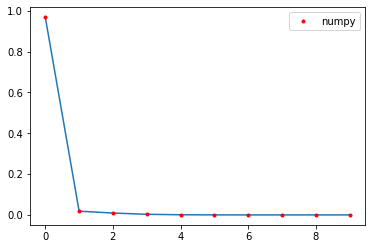

In [5]:
plt.plot(spikes[0, :], np.exp(-nll.data.numpy()[0, :]))
bins = np.arange(max_count)

if likelihood_type == 'NB':
    prbs = utils.stats.nb_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), r_inv[0].item(), 1.0)
elif likelihood_type == 'ZIP':
    prbs = utils.stats.zip_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), alpha[0].item(), 1.0)
elif likelihood_type == 'CMP':
    prbs = utils.stats.cmp_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), np.exp(log_nu[0].item()), 1.0)
elif likelihood_type == 'P':
    prbs = utils.stats.poiss_count_prob(
        bins, rates[0, 0, 0].numpy()*likelihood.tbin.item(), None, 1.0)
    
plt.plot(bins, prbs, 'r.', label=r'numpy')
plt.legend()
plt.show()

In [6]:
### sample ###
rate = np.linspace(0, 10, 100)[None, None, :].repeat(100, axis=0)*10
syn_train = likelihood.sample(rate, [0], XZ=None)


### empirical count mean and variance ###
m = syn_train.mean(0)
v = syn_train.var(0)

plt.scatter(m, v)

nx = np.linspace(0, m.max())
plt.plot(nx, nx*(1+nx*alpha.numpy()[0]))
plt.show()

plt.hist(syn_train.flatten(), bins=np.arange(max_count+1)-.5)
plt.show()

TypeError: __init__() missing 1 required positional argument: 'neurons'

In [8]:
### rebinning ###
bin_size = 100
rc_ts = []

for k in range(100):
    tbin, resamples, rc_t, _ = utils.neural.bin_data(bin_size, sample_bin, syn_train[k], 
                                                            syn_train.shape[-1], (), average_behav=False, binned=True)
    rc_ts.append(rc_t)
    
rc_ts = np.array(rc_ts)

NameError: name 'sample_bin' is not defined

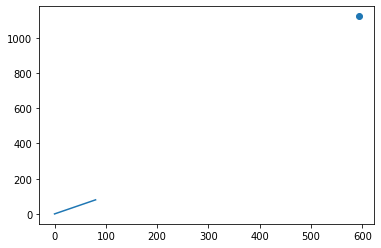

In [85]:
mean_act = (rc_ts).mean(0)
var_act = (rc_ts).var(0)

plt.scatter(mean_act, var_act)
nx = np.linspace(0, 80)
plt.plot(nx, nx*(1+nx*r_inv.numpy()[0]))
plt.show()

## 2. UCM

In [24]:
import numpy as np
import scipy.special as sps

import matplotlib.pyplot as plt

In [96]:
K = 15
C = 15

In [97]:
N_samps = 3

f = np.random.randn(N_samps, C)

In [98]:
def phi(f):
    expansion = [f, np.exp(f)]
    expanded = np.concatenate(expansion, axis=-1)
    return expanded  # (samps, expand_C)

expand_C = 2 * C


def compute_P(f, phi, W, b):
    a = (W[None, ...] @ phi(f)[..., None])[..., 0] + b
    return sps.softmax(a, axis=-1)

In [99]:
W = np.random.randn(K + 1, expand_C) * 0.0
W[:, C:] -= 1.
W[:, :C] += np.arange(K + 1)[:, None]
b = np.random.randn(K + 1) * 0.0 - sps.gammaln(np.arange(K + 1) + 1)

P = compute_P(f, phi, W, b)

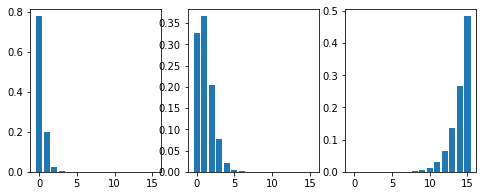

In [103]:
fig, axes = plt.subplots(1, N_samps, figsize=(8, 3))

for tr in range(N_samps):
    axes[tr].bar(np.arange(K+1), P[tr, :])

plt.show()